In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def batch_convert_folder(folder_path, extension=".txt"):
    """
    Converts all .dat files in a folder to .txt step profiles.
    Saves outputs next to input files.

    Parameters:
        folder_path (str): Path to directory with .dat files
        extension (str): Output extension
    """
    files = [f for f in os.listdir(folder_path) if f.endswith(".dat")]
    data = {}
    for fname in files:
        file_path = os.path.join(folder_path, fname)
        z = convert_dat(file_path, extension)
        data.update({fname:z})
    return data

def batch_convert_file(file, extension=".txt"):
    """
    Converts .dat file(s) to .txt step profiles.
    Saves outputs next to input files.

    Parameters:
        file (str/list): Path to directory with .dat file
        extension (str): Output extension
    """
    if isinstance(file,list):
        files = file
    else:
        files = [file]
    data = {}
    for file_path in files:
        fname = os.path.basename(file_path)
        z = convert_dat(file_path, extension)
        data.update({fname:z})
    return data   

def convert_dat(file_path, extension=".txt"):
    try:
        z = P7_dat2Z(file_path)
        folder_path = os.path.dirname(file_path)
        fname = os.path.basename(file_path)
        output_name = os.path.splitext(fname)[0] + extension
        out_path = os.path.join(folder_path, output_name)
        data = np.column_stack((np.arange(len(z)),z))
        np.savetxt(out_path, data, fmt="%.3f",delimiter='\t\t\t',header="# Points\t\t\tZ\t\t\t")
        print(f"Saved: {output_name}")
        return np.array(z)
    except Exception as e:
        print(f"Failed on {fname}: {e}")


def decode_fixed_point(int_part, frac_part):
    # frac_part is signed int16 → convert to unsigned uint16 interpretation
    frac_unsigned = frac_part.astype('uint16')
    return int_part + frac_unsigned / 65536.0

def auto_detect_data_block_after_zeros(data, zero_run=2000, jump_thresh=10000):
    """
    Detect the start of the Z data block after a long run of zeros.

    Parameters:
        data (np.ndarray): int16 array of the .dat file
        zero_run (int): number of consecutive zeros to search for
        window (int): window size for std dev scan
        std_thresh (float): minimum std dev to detect structured data
        jump_thresh (float): jump threshold in Z_int to detect block end

    Returns:
        (start, end): start and end in the detected block
    """
    last_zero_index = None

    # Step 1: Find the last run of zeros
    for i in range(len(data) - zero_run):
        if np.all(data[i:i + zero_run] == 0):
            last_zero_index = i

    if last_zero_index is None:
        return None, None

    start_scan = last_zero_index + zero_run

    # Step 2: Look for high-variance window after that point
    for j in range(start_scan, len(data), 2):
        segment = data[j:]
        # Attempt to detect sharp jump in Z_int part
        z_int = segment[1::2]  # assume int-frac alignment
        dz = np.diff(z_int)
        jumps = np.where(np.abs(dz) > jump_thresh)[0]
        if len(jumps) > 0:
            end = j + 2 * (jumps[0] + 1)
            return j, end  # start, end
    return None, None

def scale_from_recipe(raw):
    if b'Z_13UM' in raw:
        return 64/10
    elif b'Z_131UM' in raw:
        return 1024/10
    elif b'Z_1048UM' in raw:
        return 64/10
    else:
        print('Unknown recipe, please scale your data with\n        x6.4 for 13um/0.0078A range\n       x102.4 for 131um/0.0781A\n       x6.4 for 1048um/0.6250A\n')
        return 1

def P7_dat2Z(file_path):
    """Decode KLA P-7 .dat binary file to extract Z arrays.

    Parameters:
        file_path (str): Path to .dat file
    Returns:
        z (np.ndarray): Z heights (Å)
    Assume:
        frac-int format
    """
    with open(file_path, "rb") as f:
        raw = f.read()
    data = np.frombuffer(raw, dtype='<i2')
    # print(raw)
    start, end = auto_detect_data_block_after_zeros(data)
    # print(start,end)
    block = data[start:end]
    z_int = block[1::2]
    z_frac = block[0::2]
    min_len = min(len(z_int),len(z_frac))
    z = decode_fixed_point(z_int[:min_len], z_frac[:min_len])
    scale = scale_from_recipe(raw)
    return -np.array(z-z[0])*scale

In [3]:
folder = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250716_Unifomity_forCorr_45deg_5As_1000A\data"
data = batch_convert_folder(folder)


Saved: 0mm.txt
Saved: 0mm_SIMPLE.txt
Saved: 10mm.txt
Saved: 12mm.txt
Saved: 14mm.txt
Saved: 16mm.txt
Saved: 18mm.txt
Saved: 20mm.txt
Saved: 22mm.txt
Saved: 24mm.txt
Saved: 2mm.txt
Saved: 4mm.txt
Saved: 6mm.txt
Saved: 8mm.txt


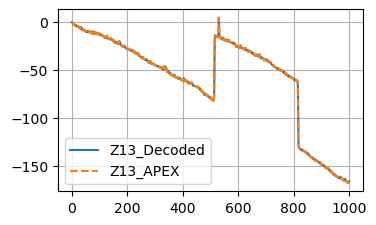

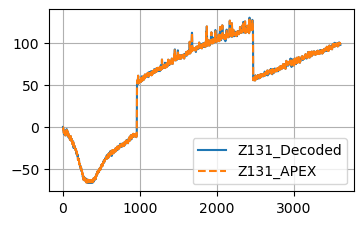

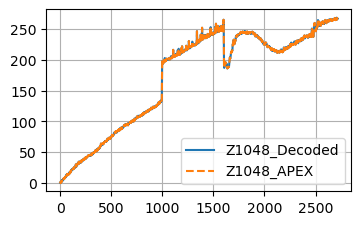

In [4]:
example_folder_path = "ExampleFiles"
fname_list = ['Z13','Z131','Z1048']
for fname in fname_list:
    plt.figure(figsize=(10/2.54, 6/2.54))
    decoded = P7_dat2Z(os.path.join(example_folder_path,fname+'.dat'))
    apex_df = pd.read_csv(os.path.join(example_folder_path,fname+'.txt'), sep=r"\s+", header=None, names=["x", "z"])
    plt.plot(decoded, label=fname + "_Decoded")
    plt.plot(apex_df['z'] - apex_df['z'][0], '--', label=fname + "_APEX")
    plt.legend()
    plt.grid()
    plt.show()
